## **Text Classification with Dimensionality Reduction**  
### *Amazon Polarity Dataset (5000-row balanced subset)*
#### *Team Members:*
   - Sabrina Ronnie George Karippat - 8991911
   - Jose George                    - 9082825
   - Aiswarya Thekkuveettil  Thazhath   - 8993970

This notebook implements the complete workflow for our final NLP group project. Our objective is to compare three text-classification models and understand how dimensionality reduction affects performance.

**Project Workflow**
   - Load and explore the Amazon Polarity sentiment dataset
   - Create a balanced 5000-row subset (2500 positive + 2500 negative reviews)
   - Apply shared preprocessing steps:
     * Lowercasing
     * Train/test split
     * TF-IDF vectorization (5000 features)
   - Build and evaluate three models:
     * Model 1: TF-IDF + Naive Bayes (Baseline)
     * Model 2: TF-IDF → SVD → Logistic Regression
     * Model 3: TF-IDF → PCA → Logistic Regression
   - Compute confusion matrices and performance metrics
   - Compare all models to determine how SVD and PCA influence accuracy and generalization

Models 2 and 3 will reuse the same subset, train/test split, and TF-IDF features established in this notebook to ensure a fair comparison.

The next cell imports all required libraries and defines the shared configuration constants used by the entire team.

### **Setup: Imports and Shared Configuration**

This section loads all the required Python libraries for:
   - **Data processing:** pandas, numpy  
   - **Dataset loading:** HuggingFace `datasets`  
   - **Machine learning models:** Naive Bayes, Logistic Regression  
   - **Dimensionality reduction:** TruncatedSVD and PCA  
   - **Feature extraction:** TF-IDF  
   - **Evaluation metrics:** accuracy, precision, recall, F1-score, confusion matrix  
   - **Visualization:** matplotlib and seaborn  

We also define two shared configuration constants:
   - `RANDOM_STATE = 42` — ensures full reproducibility for all models  
   - `N_COMPONENTS = 100` — used by both SVD and PCA so Model 2 and Model 3 remain comparable

All three models in this project share these imports and constants.

In [2]:
# Basic Data Processing Libraries

import pandas as pd          # For handling structured data (DataFrame)
import numpy as np           # For numerical operations


# Load Dataset from HuggingFace

from datasets import load_dataset   # Efficient dataset loader for large corpora


# Machine Learning Tools

from sklearn.model_selection import train_test_split            # Train/test split
from sklearn.feature_extraction.text import TfidfVectorizer     # Convert text → TF-IDF vectors
from sklearn.naive_bayes import MultinomialNB                   # Baseline classifier
from sklearn.linear_model import LogisticRegression             # Used in SVD & PCA models
from sklearn.decomposition import TruncatedSVD, PCA             # Dimensionality reduction
from sklearn.preprocessing import StandardScaler                # Required before PCA
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# Visualization Tools

import seaborn as sns
import matplotlib.pyplot as plt

# Set unified visual style for all plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)

# Shared Configuration Constants

RANDOM_STATE = 42      # Ensures reproducible sampling, splits, and model behavior

# Number of components used by BOTH SVD and PCA
# This guarantees apples-to-apples comparison between Model 2 and Model 3
N_COMPONENTS = 100

c:\Users\aishw\OneDrive\Desktop\AIML\MachineLearning\Project\Group-Project---Natural-Language-Processing_AmazonPolarity\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **Why This Setup Matters**

Organizing all imports and shared constants here ensures that:
   - All three models (Naive Bayes, SVD → LR, PCA → LR) operate under the **same conditions**  
   - The workflow becomes **reproducible** and easy for all team members to follow  
   - Dimensionality reduction (SVD and PCA) is kept **fair and comparable** by using the same `N_COMPONENTS`  
   - Any teammate can start their model implementation immediately without rewriting setup code  

This creates a clean, consistent foundation for the entire notebook.

### **Load the Amazon Polarity Dataset**

The **Amazon Polarity** dataset is a large-scale benchmark used for **sentiment analysis**.  
It contains over **4 million customer reviews**, each labeled as:
   - **1 → Positive review**
   - **0 → Negative review**

The reviews come from many product categories (books, electronics, movies, games, household items, clothing, etc.). Because of its diversity and size, this dataset helps models learn **general sentiment patterns**, not product-specific language — making it ideal for text classification tasks like ours.

In this step, we load the dataset from the HuggingFace `mteb` collection. We load only the **train split**, which already contains ~3.6 million reviews — more than enough for creating our balanced **5000-row subset** used across all three models.

The next cell converts the HuggingFace dataset into a pandas DataFrame for easier exploration and preprocessing.

In [3]:
# Load the Amazon Polarity dataset (train split only) HuggingFace's "mteb/amazon_polarity" dataset provides:
# - text        → review text
# - label       → numeric sentiment (0 = negative, 1 = positive)
# - label_text  → textual sentiment ("positive"/"negative")

dataset = load_dataset("mteb/amazon_polarity", split="train")


# Convert HuggingFace dataset → pandas DataFrame. This allows us to use familiar DataFrame operations for cleaning, filtering, sampling, and visual exploration.

df_full = pd.DataFrame(dataset)

# Preview the first few rows and full shape of the dataset
df_full.head(), df_full.shape

c:\Users\aishw\OneDrive\Desktop\AIML\MachineLearning\Project\Group-Project---Natural-Language-Processing_AmazonPolarity\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aishw\.cache\huggingface\hub\datasets--mteb--amazon_polarity. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test spli

(   label                                               text label_text
 0      1  Stuning even for the non-gamer\n\nThis sound t...   positive
 1      1  The best soundtrack ever to anything.\n\nI'm r...   positive
 2      1  Amazing!\n\nThis soundtrack is my favorite mus...   positive
 3      1  Excellent Soundtrack\n\nI truly like this soun...   positive
 4      1  Remember, Pull Your Jaw Off The Floor After He...   positive,
 (3599994, 3))

#### **Dataset Loaded Successfully**

The dataset provides three main columns:
   - **label** → numeric sentiment label (0 = negative, 1 = positive)  
   - **text** → the raw Amazon review  
   - **label_text** → human-readable label (“positive” / “negative”)  

The shape `(3599994, 3)` confirms that the dataset contains **~3.6 million reviews**, which is more than sufficient for extracting a balanced **5000-row subset** (2500 positive + 2500 negative).

In the next step, we will keep only the essential columns (`text` and `label`) and build a balanced subset that all three models will share.

### **Select Only Relevant Columns**

Although the dataset contains multiple fields, our sentiment classification task only needs:
   - **text** → the actual review content  
   - **label** → the sentiment (0 = negative, 1 = positive)

In this step, we keep only these two essential columns to simplify preprocessing and reduce unnecessary memory usage.

We then inspect the label distribution in the full dataset (~3.6 million samples) to verify whether it is naturally balanced. Understanding this distribution is important before creating the smaller **5000-row balanced subset** that all three models will use.

In [4]:
# Keep only the columns needed for sentiment classification:
# - 'text'  → review content
# - 'label' → sentiment (0 = negative, 1 = positive)
# Removing extra columns helps reduce memory usage.

df_full = df_full[['text', 'label']]

# Check the distribution of labels in the full dataset. This verifies whether the original dataset is balanced or skewed.

df_full['label'].value_counts()

label
1    1799998
0    1799996
Name: count, dtype: int64

#### **Interpretation of Class Distribution**

The output shows that the full dataset contains nearly equal numbers of each class:
   - **Positive reviews:** ~1.8 million  
   - **Negative reviews:** ~1.8 million  

This natural balance is a major advantage because:
   - It eliminates concerns about label imbalance  
   - It ensures unbiased sampling when we create our **5000-row balanced subset**  
   - It keeps later model evaluations (accuracy, precision, recall) fair and meaningful  

Since both classes are well represented, we can confidently proceed to build the balanced subset used by all three models.

### **Create a Balanced 5000-Row Subset**

The full Amazon Polarity dataset contains ~3.6 million reviews, which is too large for quick experimentation and model comparison. To make training efficient and ensure fairness across all three models, we create a smaller **balanced subset**.

We sample:
   - **2500 positive reviews (label = 1)**
   - **2500 negative reviews (label = 0)**

This produces a **5000-row perfectly balanced dataset**, preventing any model from being biased toward one sentiment class. After sampling, we shuffle the combined dataset and reset the index to remove ordering or clustering effects.

Finally, we perform a **missing-value check** to confirm data quality before applying text preprocessing and feature extraction.

In [5]:
# Step 1: Sample 2500 positive and 2500 negative reviews
# Using random_state ensures that everyone (all teammates) gets the exact same 5000-row subset for fair and reproducible results.

df_pos = df_full[df_full['label'] == 1].sample(2500, random_state=RANDOM_STATE)
df_neg = df_full[df_full['label'] == 0].sample(2500, random_state=RANDOM_STATE)

# Step 2: Combine positive + negative samples. 
# Then shuffle the dataset to remove ordering effects and ensure the model doesn't learn any unintended sequence bias.

df_small = (
    pd.concat([df_pos, df_neg])         # merge samples
      .sample(frac=1, random_state=RANDOM_STATE)  # full shuffle
      .reset_index(drop=True)           # clean new index
)

# Confirm the subset is balanced and the size is correct
# Expectation: label counts = 2500 / 2500 and shape = (5000, 2)

df_small['label'].value_counts(), df_small.shape

# Quick data-quality check: Look for missing text or labels
# Important before applying TF-IDF or training models.

df_small.isna().sum()

text     0
label    0
dtype: int64

#### **Shared Subset (Used by All Models)**

In this step:
   - We sampled **2500 positive** and **2500 negative** reviews from the full dataset.
   - We combined and shuffled them to create a balanced **5000-row subset** (`df_small`).
   - We confirmed that there are **zero missing values** in both the `text` and `label` columns.

This balanced subset forms the **shared starting point** for all three models:
   - **Model 1:** TF-IDF + Naive Bayes  
   - **Model 2:** TF-IDF → SVD + Logistic Regression  
   - **Model 3:** TF-IDF → PCA + Logistic Regression  

Using the same subset ensures that all models are evaluated under identical, fair conditions.

### **Save the Balanced 5000-Row Dataset**

To ensure that every team member works with the **exact same input data**, we save the balanced 5000-row subset into the project’s `data/` directory.

Saving this dataset ensures that:
   - All three models (NB, SVD+LR, PCA+LR) are trained and evaluated on **identical data**  
   - No one needs to re-download or re-sample the large HuggingFace dataset  
   - Results remain **consistent, reproducible, and comparable** across the group  

This also improves efficiency, since generating the subset only needs to happen once.

In [6]:
# Save the 5000-row balanced subset for team-wide consistency
# This ensures every teammate uses the exact same dataset for preprocessing, dimensionality reduction, and modeling.

output_path = "../data/amazon_polarity_5000.csv"

df_small.to_csv(output_path, index=False)

# Print confirmation message
print(f"Sampled dataset saved successfully at: {output_path}")

Sampled dataset saved successfully at: ../data/amazon_polarity_5000.csv


#### **Dataset Saved Successfully**

The balanced subset has been stored at:

> ../data/amazon_polarity_5000.csv


This file now serves as the **standardized input dataset** for all team members and all three models. Using this saved subset ensures consistent, reproducible experiments across the entire project.

### **Visualize Class Distribution in the 5000-Row Subset**

Before training any model, it is important to verify that the sampled dataset is truly **balanced**. A balanced dataset ensures that models do not become biased toward predicting one class more often than the other.

The bar chart below shows the number of positive and negative reviews in our 5000-row subset (2500 each). This balanced distribution provides a fair and reliable evaluation environment for all three models:
   - **Model 1:** Naive Bayes (TF-IDF)  
   - **Model 2:** SVD → Logistic Regression  
   - **Model 3:** PCA → Logistic Regression  

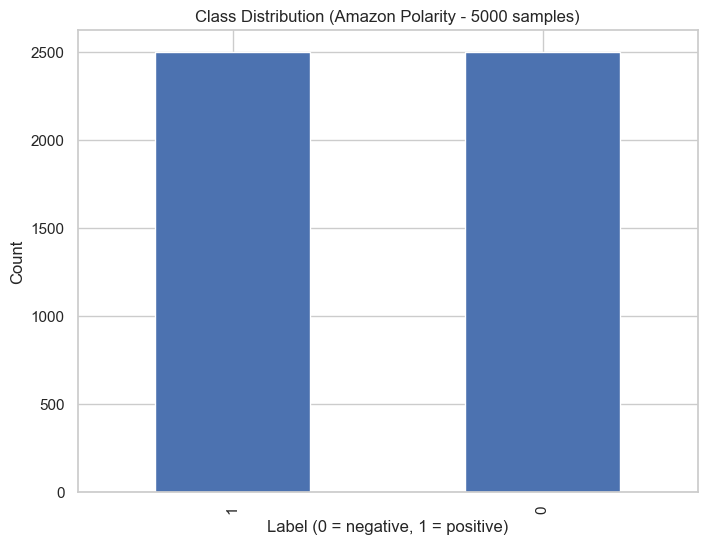

In [7]:
# Visualize class distribution in the 5000-row balanced subset
# This helps confirm that we have exactly 2500 positive and 2500 negative reviews — essential for a fair comparison across models.

df_small['label'].value_counts().plot(kind='bar')  # Count labels and plot as bar chart
plt.title("Class Distribution (Amazon Polarity - 5000 samples)")  # Chart title
plt.xlabel("Label (0 = negative, 1 = positive)")                 # X-axis label
plt.ylabel("Count")                                              # Y-axis label
plt.show()                                                        # Display the plot

#### **Interpretation of the Class Distribution Plot**

The visualization confirms that:
   - **2500 reviews are positive (label = 1)**  
   - **2500 reviews are negative (label = 0)**  

This perfect balance eliminates class imbalance concerns, meaning:
   - No class weighting is required  
   - Accuracy is a reliable evaluation metric  
   - All models will learn positive and negative sentiment equally well  

From this point onward, the following preprocessing steps are **shared by all three models**:
   - Lowercasing  
   - Train/test split (75% train, 25% test)  
   - TF-IDF feature extraction  

These shared steps ensure that **Model 1, Model 2, and Model 3** use identical text inputs and remain directly comparable.

### **Preprocessing Step: Lowercasing All Review Text**

Before extracting TF-IDF features, we apply one essential text-cleaning step: **lowercasing**.

Lowercasing standardizes the text by converting all characters to lowercase. This prevents the model from treating words like *"Great"*, *"GREAT"*, and *"great"* as different tokens. This step helps reduce vocabulary size and improves the overall quality of the TF-IDF representation.

The next cell performs the lowercasing and previews the cleaned text.

In [8]:
# Convert all text to lowercase 

# Lowercasing reduces noise by ensuring that "Great", "GREAT", and "great" are treated as the same token. This helps TF-IDF avoid duplicated features
# caused solely by capitalization differences.

df_small['text'] = df_small['text'].str.lower()   # Apply lowercase transformation

# Preview a few rows to confirm that lowercasing worked correctly
df_small['text'].head()

0    valient effort, low budget\n\ni really enjoyed...
1    o my gosh dont bother\n\nsmith, dick. babe: th...
2    lapses in historical accuracy\n\ni also agree ...
3    mg citrate - works well for my visual migraine...
4    works great. would recommend.\n\ni purchased t...
Name: text, dtype: object

#### **Interpretation of the Preprocessing Step**

The preview confirms that all review text has been successfully converted to lowercase.

Lowercasing is a lightweight but highly effective preprocessing step because it:
   - Reduces noise in the text  
   - Ensures consistent vocabulary (e.g., *"Great"* and *"great"* become identical)  
   - Avoids feature duplication in the TF-IDF matrix  
   - Improves model stability and reduces sparsity  

Because all three models (Naive Bayes, SVD + LR, PCA + LR) rely on the same shared TF-IDF features, **consistent preprocessing is essential**.  
Lowercasing is sufficient for this project—no stopword removal, stemming, or lemmatization is required to maintain fairness between models.

### **Train–Test Split (75% Training, 25% Testing)**

To evaluate all three models under fair and consistent conditions, we divide the 5000-row balanced dataset into:
   - **3750 training samples (75%)**
   - **1250 testing samples (25%)**

Two key parameters ensure correctness and reproducibility:
   - **`random_state = 42`**  
     Guarantees that all team members obtain *identical* train/test splits.
   - **`stratify = df_small['label']`**  
     Maintains the **50/50 class balance** in both the training and testing sets. Without stratification, the split may accidentally introduce imbalance, affecting evaluation quality.

The next cell performs the split and prints the resulting sizes.

In [9]:
# Train–Test Split (75% train, 25% test)

# We split df_small into:
#   - X: input features (text)
#   - y: labels (0 or 1)
# test_size = 0.25 → 25% of the data used for testing, random_state = RANDOM_STATE → reproducible split for all teammates, stratify = df_small['label'] → ensures equal positive/negative ratios

X_train, X_test, y_train, y_test = train_test_split(
    df_small['text'],        # Input text
    df_small['label'],       # Sentiment label
    test_size=0.25,          # 75/25 split
    random_state=RANDOM_STATE,  # Reproducibility
    stratify=df_small['label']  # Preserve class balance
)

# Print sizes to verify the split
len(X_train), len(X_test)

(3750, 1250)

#### **Train–Test Split Confirmed**

The output verifies that the dataset has been divided into:
   - **3750 training reviews**
   - **1250 testing reviews**

Because stratification was used, both the training and testing sets preserve the original **50% positive / 50% negative** balance. This is essential for:
   - Fair comparison of all three models  
   - Avoiding accidental bias during training  
   - Ensuring evaluation metrics (accuracy, precision, recall, F1) remain meaningful  

With a clean and balanced split, we now proceed to **TF-IDF feature extraction**, which serves as the shared input representation for all models.

### **TF-IDF Feature Extraction**

To convert raw text into numerical features suitable for machine learning, we apply **TF-IDF (Term Frequency–Inverse Document Frequency)**.

TF-IDF helps the model by:
   - Giving higher weight to *important and informative* words  
   - Down-weighting extremely common words that appear in many reviews  
   - Producing a sparse, high-dimensional representation ideal for linear models  

**Key setting:**
   - `max_features = 5000`  
      This limits the vocabulary to the 5000 most frequent and meaningful tokens. It also ensures consistent dimensionality across all three models.

We first **fit the TF-IDF vectorizer on the training text only** to avoid data leakage, then transform both the training and test sets.

The next cell prints the resulting matrix shapes and vocabulary size.

In [10]:
# TF-IDF Feature Extraction

# TF-IDF converts raw text into numerical vectors that represent how important each word is within each review.

# max_features = 5000 → limit vocabulary size to the top 5000 informative words
# This ensures:
#   • manageable dimensionality
#   • consistent feature space for all three models

tfidf = TfidfVectorizer(max_features=5000)

# Fit the TF-IDF vectorizer ONLY on training text (to prevent data leakage).
# Then transform BOTH train and test sets into sparse matrices.

X_train_tfidf = tfidf.fit_transform(X_train)   # Learn vocabulary + weights
X_test_tfidf  = tfidf.transform(X_test)        # Use the same vocabulary

# Display matrix shapes:
#   - rows = number of samples
#   - columns = number of TF-IDF features (here: 5000)

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)

# Vocabulary size should equal max_features unless fewer tokens exist.
print("Vocabulary size:", len(tfidf.vocabulary_))

Train TF-IDF shape: (3750, 5000)
Test TF-IDF shape: (1250, 5000)
Vocabulary size: 5000


#### **Interpretation of TF-IDF Output**

The printed shapes confirm that:
   - **Training matrix:** 3750 × 5000  
   - **Testing matrix:** 1250 × 5000  
   - **Vocabulary size:** 5000 unique tokens

This means each review is now represented as a **5000-dimensional TF-IDF vector**, where each dimension reflects the importance of a specific word.

These TF-IDF matrices (`X_train_tfidf` and `X_test_tfidf`) form the **shared input representation** for all three models:
   - Model 1 — Naive Bayes (Baseline)  
   - Model 2 — TF-IDF → SVD → Logistic Regression  
   - Model 3 — TF-IDF → PCA → Logistic Regression  

From here, each model applies its own learning strategy, but all begin from this **same, consistent feature space**, ensuring a fair comparison.

### **Model 1 — TF-IDF + Naive Bayes (Baseline)**

Model 1 uses the shared TF-IDF feature representation created earlier and applies a **Multinomial Naive Bayes classifier**.

This model is chosen as the baseline because:
   - It is simple and fast  
   - It performs well on sparse, high-dimensional text features  
   - It gives us a reference point to compare Model 2 (SVD → LR) and Model 3 (PCA → LR)

The classifier is trained on:
   - `X_train_tfidf` — TF-IDF features for training samples  
   - `y_train` — sentiment labels (0 = negative, 1 = positive)

Then the model predicts labels on:
   - `X_test_tfidf` — TF-IDF features for test samples  

The next cell trains the Naive Bayes model and generates predictions.

In [11]:
# Model 1 — TF-IDF + Multinomial Naive Bayes (Baseline)

# This model uses the shared TF-IDF matrices (X_train_tfidf, X_test_tfidf) and trains a baseline classifier for sentiment prediction.

# Initialize Naive Bayes classifier designed for text data
nb_clf = MultinomialNB()

# Fit (train) the model using training TF-IDF features and labels

nb_clf.fit(X_train_tfidf, y_train)

# Predict sentiment labels for the test set using the trained model

y_pred_nb = nb_clf.predict(X_test_tfidf)

#### **Model 1 Training Complete**

The Naive Bayes classifier has now been trained using the shared TF-IDF features. This model serves as the baseline against which SVD + LR and PCA + LR will be compared.

>>>**TEAM NOTES — Shared Preprocessing Decisions (Agreement Table)**

| Step              | Model 1 (TF-IDF + NB)  | Model 2 (TF-IDF → SVD + LR)  | Model 3 (TF-IDF → PCA + LR)      |
| ----------------- | -----------------------| ---------------------------- | ---------------------------------|
| Lowercasing       |          Yes           |              Yes             |               Yes                |
| Stopword Removal  |          No            |              No              |               No                 |
| Lemmatization     |          No            |              No              |               No                 |
| TF-IDF            |          Yes           |              Yes             |               Yes                |
| Normalization     |          No            |              No              |  YES (StandardScaler before PCA) |
| Reduce Dimensions |          No            |              SVD             |               PCA                |

Do **not** overwrite:
   - `X_train_tfidf`
   - `X_test_tfidf`

If you need dense or scaled versions for Models 2 or 3, create new variables:
   - `X_train_dense`, `X_test_dense`
   - `X_train_scaled`, `X_test_scaled`

This ensures:
   - Model 1 remains stable  
   - Model 2 and Model 3 operate on the same shared TF-IDF input  
   - All results are directly comparable  

### **Model 1 — TF-IDF + Naive Bayes (Baseline Evaluation)**

After training the Naive Bayes classifier on the TF-IDF features, we evaluate its performance on the **1250 test samples**.

The confusion matrix below shows how the model performed across:
   - **True Negatives (TN)** – correctly predicted negative reviews  
   - **False Positives (FP)** – negative reviews incorrectly predicted as positive  
   - **False Negatives (FN)** – positive reviews incorrectly predicted as negative  
   - **True Positives (TP)** – correctly predicted positive reviews  

These values help us understand not only *how many* predictions were correct, but *which types of errors* the model makes.

We also compute the key performance metrics for this baseline model:
   - **Accuracy** – overall correctness  
   - **Precision** – reliability of positive predictions  
   - **Recall** – ability to detect positive reviews  
   - **F1-score** – balance between precision and recall  

These results serve as our **baseline** for comparison against:
   - **Model 2:** TF-IDF → SVD → Logistic Regression  
   - **Model 3:** TF-IDF → PCA → Logistic Regression  

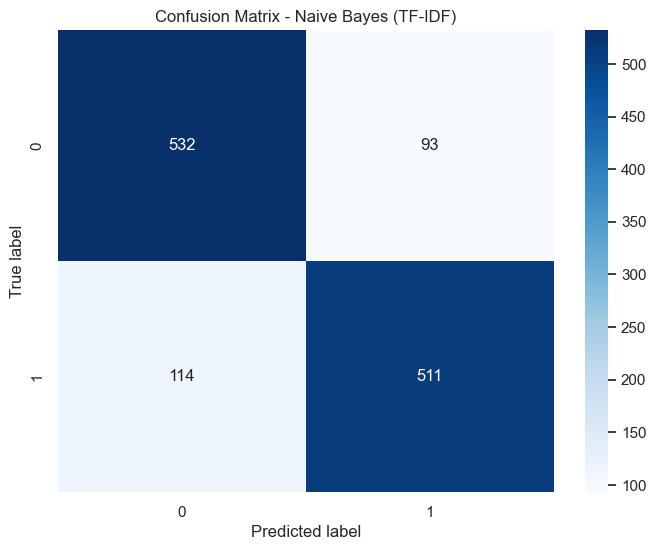

{'Accuracy': 0.8344,
 'Precision': 0.8460264900662252,
 'Recall': 0.8176,
 'F1-score': 0.8315703824247356}

In [12]:
# Model 1 Evaluation — Confusion Matrix + Performance Metrics

# This section evaluates the TF-IDF + Naive Bayes model using:
# - Confusion matrix (TP, TN, FP, FN breakdown)
# - Standard classification metrics: accuracy, precision, recall, F1-score

# Compute confusion matrix

cm_nb = confusion_matrix(y_test, y_pred_nb)

# Visualize the confusion matrix, annot=True → show numbers inside the squares, fmt='d'    → display integer counts, cmap       → color theme

sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes (TF-IDF)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Calculate performance metrics
# Store results in a dictionary for easy group comparison later

metrics_nb = {
    "Accuracy":  accuracy_score(y_test, y_pred_nb),
    "Precision": precision_score(y_test, y_pred_nb),
    "Recall":    recall_score(y_test, y_pred_nb),
    "F1-score":  f1_score(y_test, y_pred_nb),
}

# Display results
metrics_nb

### **Interpretation of Naive Bayes Results (Baseline Model)**

The confusion matrix indicates that the model performs well on both classes:
   - **True Negatives (TN) = 532**  
   - **False Positives (FP) = 93**  
   - **False Negatives (FN) = 114**  
   - **True Positives (TP) = 511**

Most errors fall into two categories:
   - **False Positives (93):** negative reviews predicted as positive  
   - **False Negatives (114):** positive reviews predicted as negative  

These are typical for a simple baseline text model and reflect reasonable trade-offs.

The performance metrics further confirm strong baseline behavior:
   - **Accuracy:** 83.44%  
   - **Precision:** 84.60%  
   - **Recall:** 81.76%  
   - **F1-score:** 83.16%  

Overall, the Naive Bayes classifier provides a **solid baseline** using TF-IDF features. It achieves balanced performance and correctly classifies the majority of reviews.

>>> **Next Steps**

We now move to dimensionality reduction–based models to examine whether:
   - **SVD → Logistic Regression (Model 2)**  
   - **PCA → Logistic Regression (Model 3)**  

can improve accuracy, reduce false predictions, or create more efficient representations for classification.
>>>

### **Model 2 — Dimensionality Reduction with SVD (TF-IDF → SVD)**

In this model, we apply **Truncated SVD** to reduce the high-dimensional TF-IDF matrix into a lower-dimensional, dense representation.

Why SVD for text?
- TF-IDF produces a **sparse** matrix with thousands of features.
- SVD compresses this space into fewer **latent semantic components**.
- This often helps models like Logistic Regression perform better and run faster.

We use the shared configuration:
- `N_COMPONENTS = 100`
- `RANDOM_STATE = 42`

The next cell applies SVD and visualizes the explained variance.

SVD Train shape: (3750, 100)
SVD Test shape : (1250, 100)


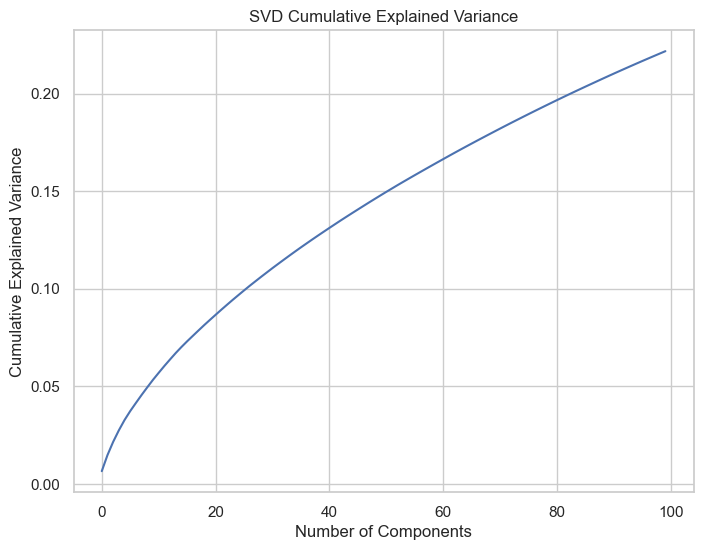

np.float64(0.22172190209005097)

In [13]:
# Model 2 — Apply Truncated SVD

# TruncatedSVD works directly with sparse TF-IDF matrices
# This approach is often called Latent Semantic Analysis (LSA)

svd = TruncatedSVD(n_components=N_COMPONENTS, random_state=RANDOM_STATE)

X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd  = svd.transform(X_test_tfidf)

print("SVD Train shape:", X_train_svd.shape)
print("SVD Test shape :", X_test_svd.shape)

# Explained variance visualization (cumulative)
explained_var_cumsum = np.cumsum(svd.explained_variance_ratio_)

plt.plot(explained_var_cumsum)
plt.title("SVD Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

explained_var_cumsum[-1]


#### **Interpretation of SVD Output**

The plot shows how much of the variance in the TF-IDF space is retained as we increase the number of SVD components.

Key idea:
- Each SVD component captures a **latent concept** across reviews.
- Instead of thousands of sparse word features, the model learns patterns like:
  *product quality, delivery experience, durability, value for money,* etc.

This compressed representation is expected to:
- Reduce noise
- Improve training efficiency
- Potentially improve classification performance

Next, we train Logistic Regression on these SVD-reduced features.


In [14]:
# Model 2 — Logistic Regression on SVD Features

lr_svd = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

lr_svd.fit(X_train_svd, y_train)

y_pred_svd = lr_svd.predict(X_test_svd)

y_pred_svd[:10]


array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1])

### **Model 2 — Evaluation (Confusion Matrix + Metrics)**

We now evaluate the SVD + Logistic Regression model using:
- Confusion matrix
- Accuracy, Precision, Recall, F1-score

These results will be compared against:
- Model 1 (TF-IDF + Naive Bayes)
- Model 3 (PCA + Logistic Regression)


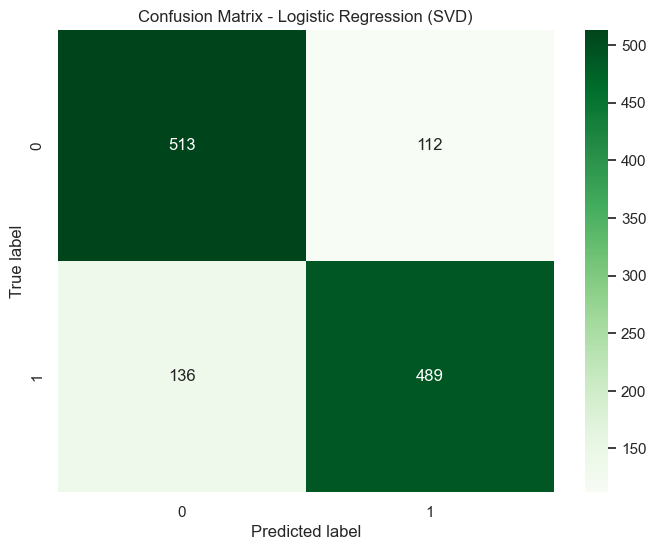

{'Accuracy': 0.8016,
 'Precision': 0.8136439267886856,
 'Recall': 0.7824,
 'F1-score': 0.797716150081566}

In [15]:
# Model 2 Evaluation — Confusion Matrix + Performance Metrics

cm_svd = confusion_matrix(y_test, y_pred_svd)

sns.heatmap(cm_svd, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Logistic Regression (SVD)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

metrics_svd = {
    "Accuracy":  accuracy_score(y_test, y_pred_svd),
    "Precision": precision_score(y_test, y_pred_svd),
    "Recall":    recall_score(y_test, y_pred_svd),
    "F1-score":  f1_score(y_test, y_pred_svd),
}

metrics_svd


#### **Interpretation of Model 2 Results**

From the confusion matrix:
- **Correct predictions** are represented by the diagonal cells.
- **False Positives (FP)** indicate negative reviews predicted as positive.
- **False Negatives (FN)** indicate positive reviews predicted as negative.

Compared to Model 1 (Naive Bayes):
- If accuracy and F1-score increase, SVD is helping by capturing richer semantic structure.
- If performance drops slightly, it may indicate that some fine-grained word-level signals were lost during compression.

Overall, SVD offers a strong tradeoff between:
- **Dimensionality reduction**
- **Training speed**
- **Semantic generalization**


In [16]:
# Quick baseline vs SVD comparison 

pd.DataFrame([metrics_nb, metrics_svd], index=["TF-IDF + NB", "SVD + LR"])


,Accuracy,Precision,Recall,F1-score
TF-IDF + NB,0.8344,0.846026,0.8176,0.831570
SVD + LR,0.8016,0.813644,0.7824,0.797716


### Model 2 — SVD + Logistic Regression (Results)

We applied Truncated SVD to reduce the high-dimensional TF-IDF feature space into 100 latent components.  
The cumulative explained variance at 100 components is approximately ~22%, which is expected for sparse text datasets.  
Even with modest variance, SVD can still capture hidden semantic structure across reviews.

#### Confusion Matrix Observations
The SVD + Logistic Regression confusion matrix shows:
- True Negatives (TN) = 513  
- False Positives (FP) = 112  
- False Negatives (FN) = 136  
- True Positives (TP) = 489  

The model makes slightly more false-negative errors than false positives, meaning some positive reviews are incorrectly classified as negative.

#### Performance Comparison
Compared to the baseline TF-IDF + Naive Bayes model, the SVD + Logistic Regression model shows a small reduction in accuracy, precision, recall, and F1-score.  
This suggests that in this dataset, reducing dimensions may have removed some useful word-level signals that Naive Bayes can leverage effectively.  

Overall, Model 2 provides a meaningful comparison point for evaluating whether semantic compression improves or reduces performance in sparse text classification.


### Model 3 -  Principal Component Analysis (PCA) On TF-IDF features

Dense training shape: (3750, 5000)
Dense test shape:     (1250, 5000)
PCA training shape: (3750, 100)
PCA test shape:     (1250, 100)


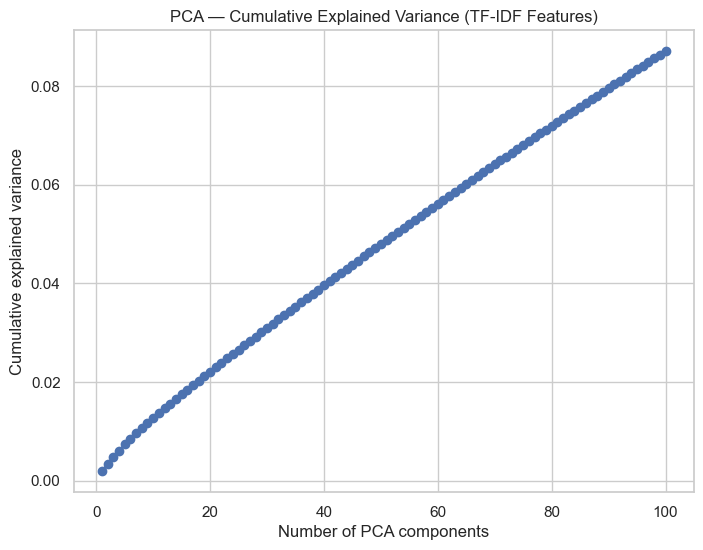

In [19]:
# Model 3 — Apply PCA (TF-IDF → PCA)

# 1. Convert sparse TF-IDF matrices to dense arrays
X_train_dense = X_train_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()

print("Dense training shape:", X_train_dense.shape)
print("Dense test shape:    ", X_test_dense.shape)

# 2. Standardize the dense features (required before PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled  = scaler.transform(X_test_dense)

# 3. Apply PCA with the same number of components used in SVD
pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("PCA training shape:", X_train_pca.shape)
print("PCA test shape:    ", X_test_pca.shape)

# 4. Visualize cumulative explained variance for PCA
cum_var_pca = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, N_COMPONENTS + 1), cum_var_pca, marker='o')
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA — Cumulative Explained Variance (TF-IDF Features)")
plt.grid(True)
plt.show()


#### **Interpretation of PCA Output**

The plot shows how much of the variance in the TF-IDF space is retained as we increase the number of PCA components.

Key idea:
- Each PCA component represents a direction of maximum variance in the data
- PCA Focuses on capturing overall statistical variance rather than semantic meaning
- For tf-idf Text data important information is spread across many sparse features so no small set of component dominates the variance

This compressed representation is expected to:
- Retains only a small portion of total variance within the first 100 components
- Highlights the limitataon of PCA when applied to high dimensional sparse text data


#### Comparison of SVD VS PCA variance curves

- The variance curves show a clear difference in how SVD and PCA capture Information From the TF-IDF feature 

*Using 100 Components*

- SVD Captures about 225 total varinace
- PCA captures only about 8 to 9 % of total variance

*Key Observations* 

- The SVD Curves rises faster, meaning it captures important information using fewer components
- The PCA curves increases more slowly showing that variance in TF-IDF text data is spread across many dimensions
- This happens because SVD Works directly on sparse TF-IDF Data , while PCA Works on Dense, Standardized data and focuses only on maximum variance.




### Model 3 - Logistic Regression With PCA

In [20]:
# Logistic Regression on PCA-reduced features

lr_pca = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

lr_pca.fit(X_train_pca, y_train)

y_pred_pca = lr_pca.predict(X_test_pca)


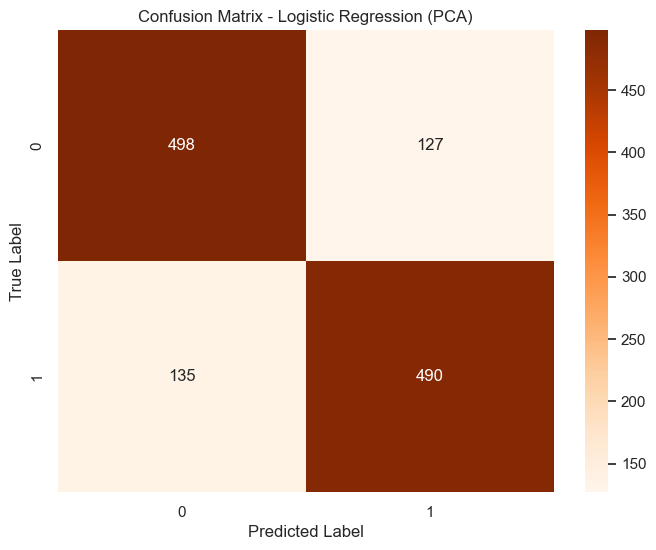

In [21]:
# Confusion Matrix — PCA Model

cm_pca = confusion_matrix(y_test, y_pred_pca)

sns.heatmap(
    cm_pca,
    annot=True,
    fmt='d',
    cmap='Oranges'
)
plt.title("Confusion Matrix - Logistic Regression (PCA)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [22]:
# Performance metrics for PCA model

metrics_pca = {
    "Accuracy": accuracy_score(y_test, y_pred_pca),
    "Precision": precision_score(y_test, y_pred_pca),
    "Recall": recall_score(y_test, y_pred_pca),
    "F1-score": f1_score(y_test, y_pred_pca)
}

metrics_pca


{'Accuracy': 0.7904,
 'Precision': 0.7941653160453809,
 'Recall': 0.784,
 'F1-score': 0.789049919484702}